In [97]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Setup path

import os
import sys

# From jupyter notebook, starting from Tensor-Completion/
'''
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
'''

# From google colab
# Add parent packages to path
sys.path.append("/content/drive/My Drive/Tensor-Completion")
sys.path.append("/content/drive/My Drive/Tensor-Completion/Code")

# Add lib directory, containing the required libraries, to path
sys.path.append("/content/drive/My Drive/lib")

In [0]:
try:
  import cupy as cp
except:
  print("cupy not available")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

from Models.CP_WOPT import CP_WOPT_Model
from Models.TT_WOPT import TT_WOPT_Model
from metrics import RSE, PSNR
from Utils import mask_img

In [0]:
def img_to_9D(img):
  img_17D = img.reshape([2]*16 + [3], order="F")
  img_9D = np.moveaxis(img_17D, [0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15, 16], range(17))\
    .reshape([4]*8 + [3], order="F") 

  return img_9D

def img_9D_to_img(img_9D, shape):
  img_17D = img_9D.reshape([2]*16 + [3], order="F")
  img = np.moveaxis(img_17D, range(17), [0, 8, 1, 9, 2, 10, 3, 11, 4, 12, 5, 13, 6, 14, 7, 15, 16])\
    .reshape(shape, order="F") 

  return img

img shape:  (256, 256, 3)


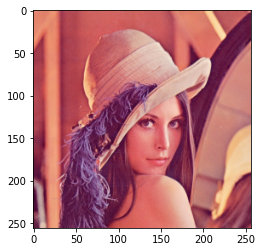

In [101]:
# Read lena image
img_path = '/content/drive/My Drive/Tensor-Completion/Code/data/lena_red.bmp'

img = cv2.imread(img_path, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)
print("img shape: ", img.shape)

img = cp.asarray(img) # If using cupy

<h2>CP-WOPT</h2>

In [0]:
def run_CP_experiment(img, missing_rates, ranks=[10], n_epochs=10000):
  best_ranks = {}
  rses = {}
  psnrs = {}
  predictions = {}

  for missing_rate in missing_rates:
    best_rse = float("inf")
    best_psnr = 0

    for rank in ranks:
      # Mask the tensor
      img_masked = mask_img(img, missing_rate)

      # Train the model
      model = CP_WOPT_Model(img_masked, rank, init="normal", optimization="ncg")
      model.train(n_epochs)

      # Compute the RSE of our prediction
      prediction = model.predict()
      prediction = prediction.clip(0, 255)
      rse = RSE(img/255, prediction/255)
      psnr = PSNR(img, prediction)

      print("rank:", rank)
      print("rse:", rse)
      print("psnr:", psnr)

      if rse < best_rse and psnr > best_psnr:
        best_ranks[f"mr_{missing_rate}"] = rank
        rses[f"mr_{missing_rate}"] = rse
        psnrs[f"mr_{missing_rate}"] = psnr
        predictions[f"mr_{missing_rate}"] = prediction

        best_rse = rse
        best_psnr = psnr

  return predictions, rses, psnrs, best_ranks

In [52]:
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
ranks = range(3, 10)
predictions, rses, psnrs, best_ranks = run_CP_experiment(img, missing_rates, ranks=ranks, n_epochs=10000)

         Current function value: 13418140.870294
         Iterations: 1082
         Function evaluations: 1675
         Gradient evaluations: 1674
rank: 3
rse: 0.22922298059388174
psnr: 17.915431196890378
         Current function value: 11124883.855317
         Iterations: 10000
         Function evaluations: 15058
         Gradient evaluations: 15058
rank: 4
rse: 0.2184721659947959
psnr: 18.332672016020677
         Current function value: 8880364.700750
         Iterations: 10000
         Function evaluations: 15058
         Gradient evaluations: 15058
rank: 5
rse: 0.2099202321123605
psnr: 18.679508346351835
         Current function value: 6847450.372774
         Iterations: 10000
         Function evaluations: 15238
         Gradient evaluations: 15238
rank: 6
rse: 0.19757925632925882
psnr: 19.20576737534715
         Current function value: 5930390.032141
         Iterations: 10000
         Function evaluations: 15162
         Gradient evaluations: 15162
rank: 7
rse: 0.202529132232

In [53]:
best_ranks

{'mr_0.85': 6, 'mr_0.9': 4, 'mr_0.95': 3, 'mr_0.98': 3, 'mr_0.99': 9}

In [54]:
rses

{'mr_0.85': 0.19757925632925882,
 'mr_0.9': 0.2702658530548211,
 'mr_0.95': 0.47546313776028387,
 'mr_0.98': 0.8431902287150467,
 'mr_0.99': 0.8380379303052673}

In [55]:
psnrs

{'mr_0.85': 19.20576737534715,
 'mr_0.9': 16.484770746453748,
 'mr_0.95': 11.578257262231507,
 'mr_0.98': 6.602083002625702,
 'mr_0.99': 6.655320792192686}

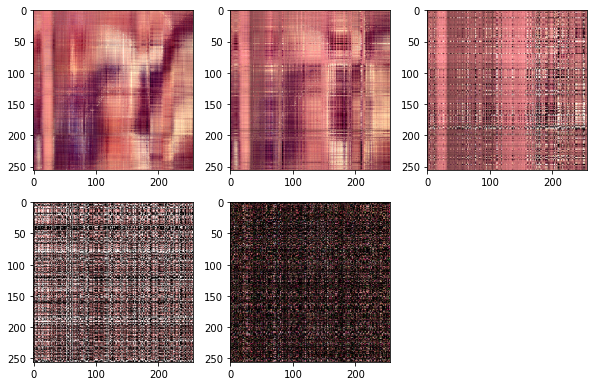

In [61]:
fig = plt.figure(figsize=(10, 10))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 3, i+1)
  plt.imshow(cp.asnumpy(prediction).astype(int))

<h2>TT-WOPT</h2>

<h3>3D</h3>

In [0]:
def run_TT_experiment(img, missing_rates, ranks=[16], n_epochs=10000, tensorize_img=False):
  best_ranks = {}
  rses = {}
  psnrs = {}
  predictions = {}

  for missing_rate in missing_rates:
    best_rse = float("inf")
    best_psnr = 0

    for rank in ranks:
      start = time.time()
      if tensorize_img:
        tt_ranks = tuple([1] + [rank] * 8 + [1])
      else:
        tt_ranks = tuple([1] + [rank] * 2 + [1])

      # Mask the tensor and tensorize to 9D
      img_masked = mask_img(img, missing_rate)
      if tensorize_img:
        img_masked = img_to_9D(img_masked)

      # Train the model
      model = TT_WOPT_Model(img_masked, tt_ranks, optimization="ncg")
      model.train(n_epochs)

      # Compute the prediction and cast back to 3D
      prediction = model.predict()
      prediction = prediction.clip(0, 255)
      if tensorize_img:
        prediction = img_9D_to_img(prediction, (256, 256, 3))

      # Compute the RSE and PSNR of our prediction
      rse = RSE(img/255, prediction/255)
      psnr = PSNR(img, prediction)

      print("rank:", rank)
      print("rse:", rse)
      print("psnr:", psnr)

      if rse < best_rse and psnr > best_psnr:
        best_ranks[f"mr_{missing_rate}"] = rank
        rses[f"mr_{missing_rate}"] = rse
        psnrs[f"mr_{missing_rate}"] = psnr
        predictions[f"mr_{missing_rate}"] = prediction

        best_rse = rse
        best_psnr = psnr

      end = time.time()
      print("time:", end-start)

  return predictions, rses, psnrs, best_ranks

In [106]:
# Run experiments with few epochs to find best ranks for each missing rate
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
ranks = range(4, 17, 2)
predictions, rses, psnrs, best_ranks = run_TT_experiment(img, missing_rates, ranks=ranks, n_epochs=2000)

         Current function value: 9540730.259105
         Iterations: 579
         Function evaluations: 960
         Gradient evaluations: 948
rank: 4
rse: 0.21026048171449563
psnr: 18.665441203133394
time: 2.30548095703125
         Current function value: 5410762.569850
         Iterations: 1508
         Function evaluations: 2846
         Gradient evaluations: 2845
rank: 6
rse: 0.19679939303051328
psnr: 19.240119211512244
time: 9.89745306968689
         Current function value: 3541079.563354
         Iterations: 2000
         Function evaluations: 3084
         Gradient evaluations: 3084
rank: 8
rse: 0.2233913638795944
psnr: 18.139266711438285
time: 11.439729928970337
         Current function value: 2240245.837593
         Iterations: 2000
         Function evaluations: 3077
         Gradient evaluations: 3077
rank: 10
rse: 0.29643664254042057
psnr: 15.681956588870573
time: 11.561070680618286
         Current function value: 1415949.702228
         Iterations: 2000
         Function

In [107]:
print("best ranks")
print(best_ranks)
print("rse")
print(rses)
print("psnr")
print(psnrs)

best ranks
{'mr_0.85': 6, 'mr_0.9': 4, 'mr_0.95': 4, 'mr_0.98': 10, 'mr_0.99': 6}
rse
{'mr_0.85': 0.19679939303051328, 'mr_0.9': 0.25018024065378086, 'mr_0.95': 0.5345373713275546, 'mr_0.98': 0.8120852728348246, 'mr_0.99': 0.8341660589135215}
psnr
{'mr_0.85': 19.240119211512244, 'mr_0.9': 17.15553418557729, 'mr_0.95': 10.561032832161985, 'mr_0.98': 6.9285616117675195, 'mr_0.99': 6.695544004096137}


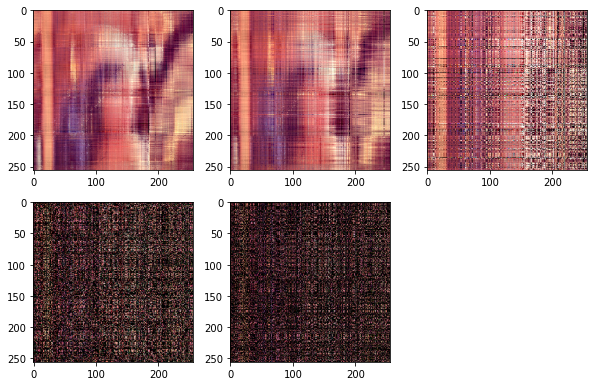

In [108]:
fig = plt.figure(figsize=(10, 10))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 3, i+1)
  plt.imshow(cp.asnumpy(prediction).astype(int))

In [0]:
# Train the models with the best ranks for each missing rate
def train_best_models(img, missing_rates, best_ranks, n_epochs=10000, tensorize_img=False):
  rses = {}
  psnrs = {}
  predictions = {}

  for missing_rate in missing_rates:
    rank = best_ranks[f"mr_{missing_rate}"]
    best_rse = float("inf")
    best_psnr = 0

    start = time.time()
    if tensorize_img:
      tt_ranks = tuple([1] + [rank] * 8 + [1])
    else:
      tt_ranks = tuple([1] + [rank] * 2 + [1])

    # Mask the tensor and tensorize to 9D
    img_masked = mask_img(img, missing_rate)
    if tensorize_img:
      img_masked = img_to_9D(img_masked)

    # Train the model
    model = TT_WOPT_Model(img_masked, tt_ranks, optimization="ncg")
    model.train(n_epochs)

    # Compute the prediction and cast back to 3D
    prediction = model.predict()
    prediction = prediction.clip(0, 255)
    if tensorize_img:
      prediction = img_9D_to_img(prediction, (256, 256, 3))

    # Compute the RSE and PSNR of our prediction
    rse = RSE(img/255, prediction/255)
    psnr = PSNR(img, prediction)

    print("mr:", missing_rate)
    print("rse:", rse)
    print("psnr:", psnr)

    rses[f"mr_{missing_rate}"] = rse
    psnrs[f"mr_{missing_rate}"] = psnr
    predictions[f"mr_{missing_rate}"] = prediction

    end = time.time()
    print("time:", end-start)

  return predictions, rses, psnrs

In [0]:
# Run experiments with few epochs to find best ranks for each missing rate
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
predictions, rses, psnrs= train_best_models(img, missing_rates, best_ranks, n_epochs=15000)

In [117]:
print("best ranks")
print(best_ranks)
print("rse")
print(rses)
print("psnr")
print(psnrs)

best ranks
{'mr_0.85': 6, 'mr_0.9': 4, 'mr_0.95': 4, 'mr_0.98': 10, 'mr_0.99': 6}
rse
{'mr_0.85': 0.1976437725322161, 'mr_0.9': 0.2574840693250235, 'mr_0.95': 0.5098365078466525, 'mr_0.98': 0.8214295543549253, 'mr_0.99': 0.830533198853069}
psnr
{'mr_0.85': 19.20293160626079, 'mr_0.9': 16.905587020802244, 'mr_0.95': 10.97197568924528, 'mr_0.98': 6.82918781731506, 'mr_0.99': 6.733454361177692}


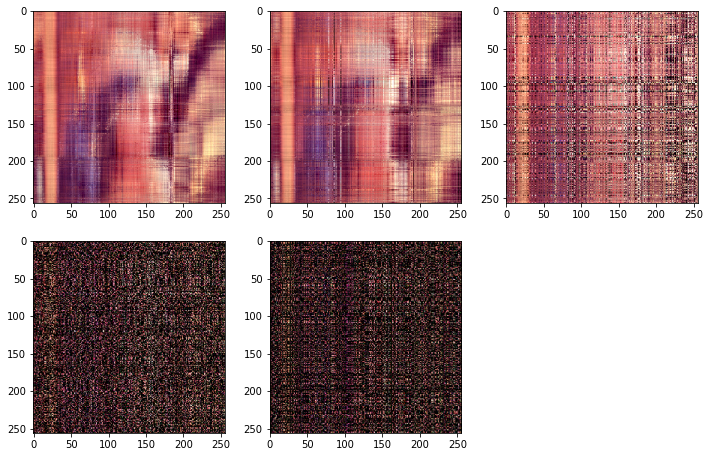

In [119]:
fig = plt.figure(figsize=(12, 12))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 3, i+1)
  plt.imshow(cp.asnumpy(prediction).astype(int))

<h3>9D</h3>

In [123]:
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
ranks = range(12, 21, 2)
predictions, rses, psnrs, best_ranks = run_TT_experiment(img, missing_rates, ranks=ranks, n_epochs=1000, tensorize_img=True)

         Current function value: 19325666.889210
         Iterations: 1000
         Function evaluations: 1579
         Gradient evaluations: 1579
rank: 12
rse: 0.24011017393210604
psnr: 17.51238305753563
time: 108.63078022003174
         Current function value: 16775717.471921
         Iterations: 1000
         Function evaluations: 1551
         Gradient evaluations: 1551
rank: 14
rse: 0.228390837537095
psnr: 17.947020761867925
time: 108.06209516525269
         Current function value: 23728588.408110
         Iterations: 1000
         Function evaluations: 1566
         Gradient evaluations: 1566
rank: 16
rse: 0.26872971027017256
psnr: 16.534280626421697
time: 108.73632001876831
         Current function value: 24627840.593978
         Iterations: 1000
         Function evaluations: 1560
         Gradient evaluations: 1560
rank: 18
rse: 0.2733561902395873
psnr: 16.386016042837273
time: 108.5774176120758
         Current function value: 62513356.549960
         Iterations: 1000
      

In [124]:
print("best ranks")
print(best_ranks)
print("rse")
print(rses)
print("psnr")
print(psnrs)

best ranks
{'mr_0.85': 14, 'mr_0.9': 16, 'mr_0.95': 14, 'mr_0.98': 12, 'mr_0.99': 12}
rse
{'mr_0.85': 0.228390837537095, 'mr_0.9': 0.1978683042387186, 'mr_0.95': 0.22794105601114514, 'mr_0.98': 0.6488029545876275, 'mr_0.99': 0.8432614082332421}
psnr
{'mr_0.85': 17.947020761867925, 'mr_0.9': 19.19306966804459, 'mr_0.95': 17.96414318533212, 'mr_0.98': 8.878337925527479, 'mr_0.99': 6.6013497975620545}


In [125]:
# Run experiments with few epochs to find best ranks for each missing rate
missing_rates = [0.85, 0.9, 0.95, 0.98, 0.99]
predictions, rses, psnrs= train_best_models(img, missing_rates, best_ranks, n_epochs=10000)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch: 5005, Loss: 30.300224418799218
Epoch: 5006, Loss: 30.2887640124361
Epoch: 5007, Loss: 30.277305158612325
Epoch: 5008, Loss: 30.26584785686412
Epoch: 5009, Loss: 30.25439210674097
Epoch: 5010, Loss: 30.242937907786676
Epoch: 5011, Loss: 30.231485259565865
Epoch: 5012, Loss: 30.220034161639376
Epoch: 5013, Loss: 30.20858461357373
Epoch: 5014, Loss: 30.197136614950587
Epoch: 5015, Loss: 30.185690165349715
Epoch: 5016, Loss: 30.17424526435467
Epoch: 5017, Loss: 30.16280191156983
Epoch: 5018, Loss: 30.151360106578746
Epoch: 5019, Loss: 30.13991984898959
Epoch: 5020, Loss: 30.128481138421872
Epoch: 5021, Loss: 30.11704397448755
Epoch: 5022, Loss: 30.105608356809924
Epoch: 5023, Loss: 30.09417428501041
Epoch: 5024, Loss: 30.08274175873314
Epoch: 5025, Loss: 30.071310777614666
Epoch: 5026, Loss: 30.059881341299118
Epoch: 5027, Loss: 30.0484534494382
Epoch: 5028, Loss: 30.03702710169307
Epoch: 5029, Loss: 30.02

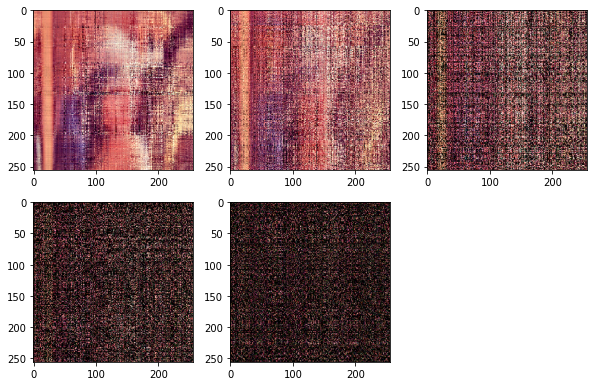

In [126]:
fig = plt.figure(figsize=(10, 10))
n_img = len(missing_rates)

for i, prediction in enumerate(predictions.values()):
  fig.add_subplot(3, 3, i+1)
  plt.imshow(cp.asnumpy(prediction).astype(int))